In [4]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [5]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'planck_wgt_flux',
            'option_wgt',
            'fac_meank',
            'klin']


def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [6]:
analysis = scripts.Analysis()

In [7]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation/crd',
                          'LW/examples/separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'co2',
                          'band03a_wn_540_620',
                          'ng_9',
                          'g_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__4',
                          'getabsth_auto__auto__semiauto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.7_.3_.7___.7_.6__.4_.5_.8_.95',
                          'bigsum',
                          'option_wgt_1',
                          'chou_0501_-_manual_abscom2_-_151f63b',
                          'atmpro_trp')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [8]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation/crd',
                          'LW/examples/separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'co2',
                          'band03a_wn_540_620',
                          'ng_9',
                          'g_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__4',
                          'getabsth_auto__auto__semiauto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.7_.3_.7___.7_.6__.4_.5_.8_.95',
                          'bigsum',
                          'option_wgt_1',
                          'chou_0501_-_manual_abscom2_-_151f63b',
                          'atmpro_trp')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(range(1, 9 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-4, 50)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 540

nband = 80

nv = 200

dv = 0.005

tsfc = 300.0

ng = 9

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   2,   4 /)

data wgt
     &     /.95, .8, .5, .4,
     &     .6, .7,
     &     .7, .3, .7/

planck_wgt_flux = 2

option_wgt = 1

klin = 6.375563e-24

include 'trp75.pro'


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

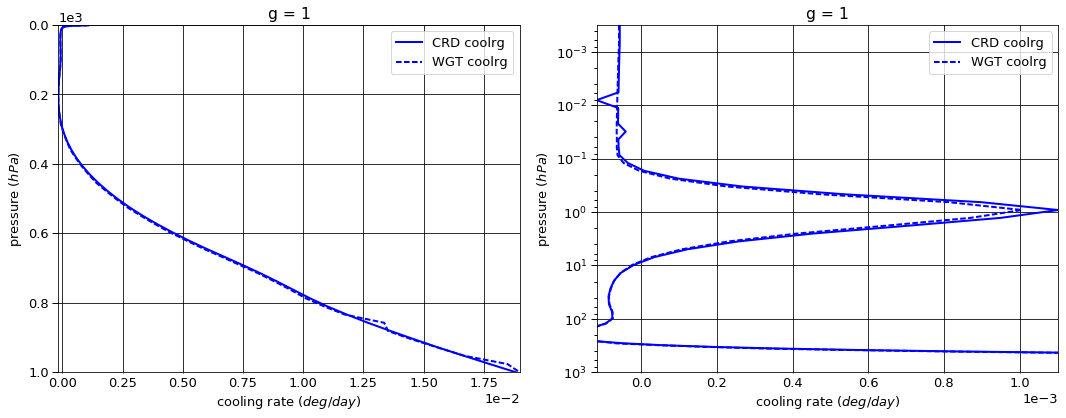

# Figure: cooling rate g-group 2

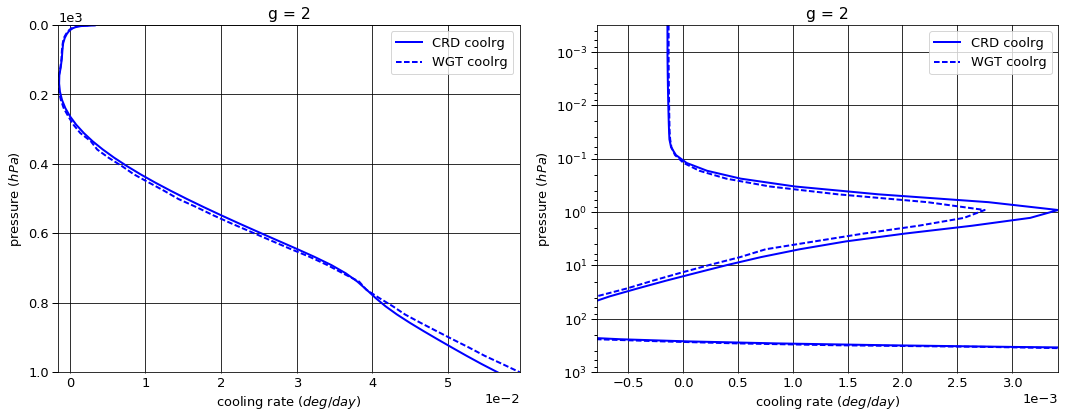

# Figure: cooling rate g-group 3

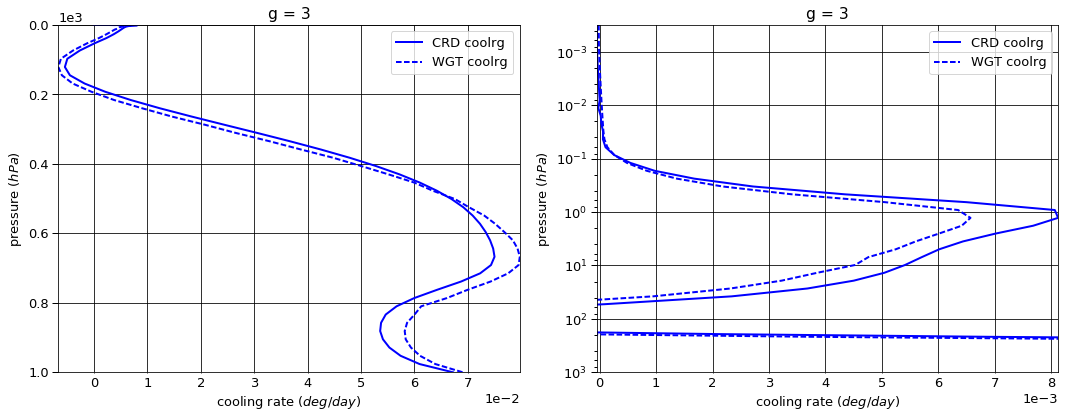

# Figure: cooling rate g-group 4

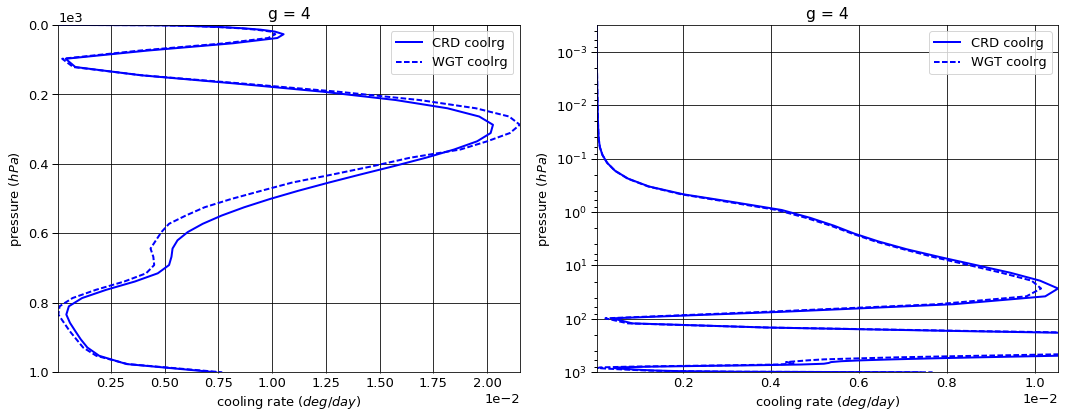

# Figure: cooling rate g-group 5

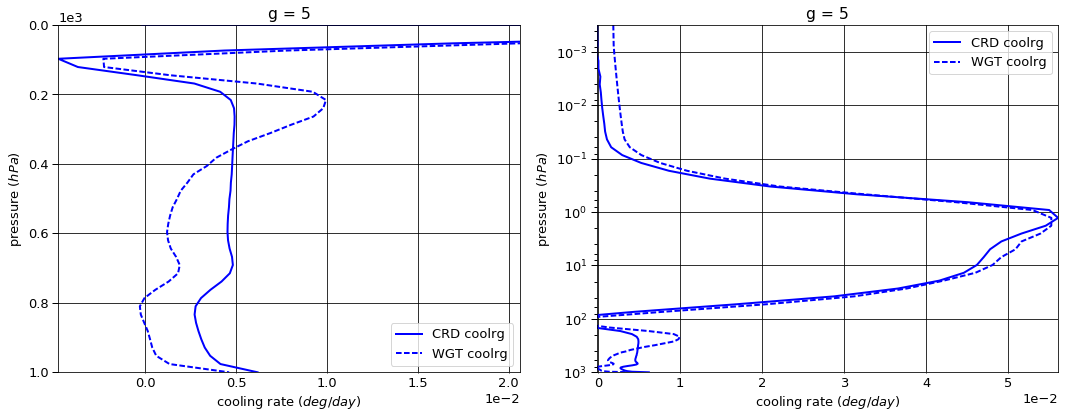

# Figure: cooling rate g-group 6

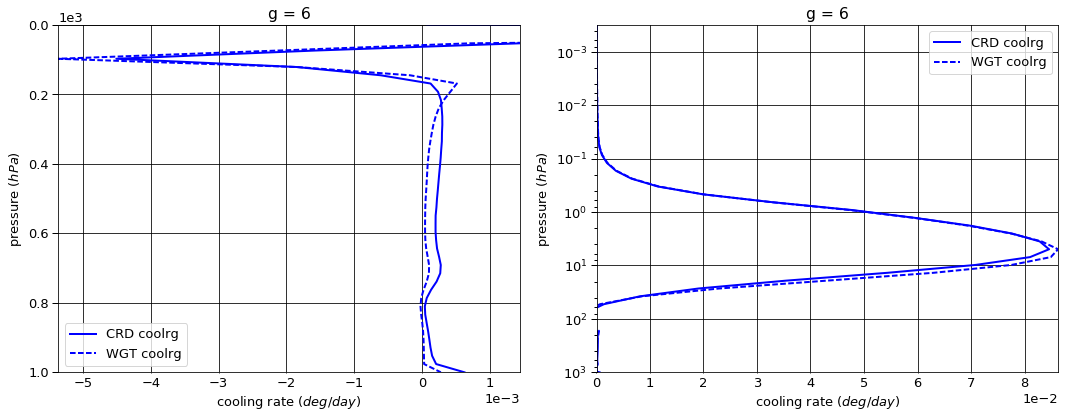

# Figure: cooling rate g-group 7

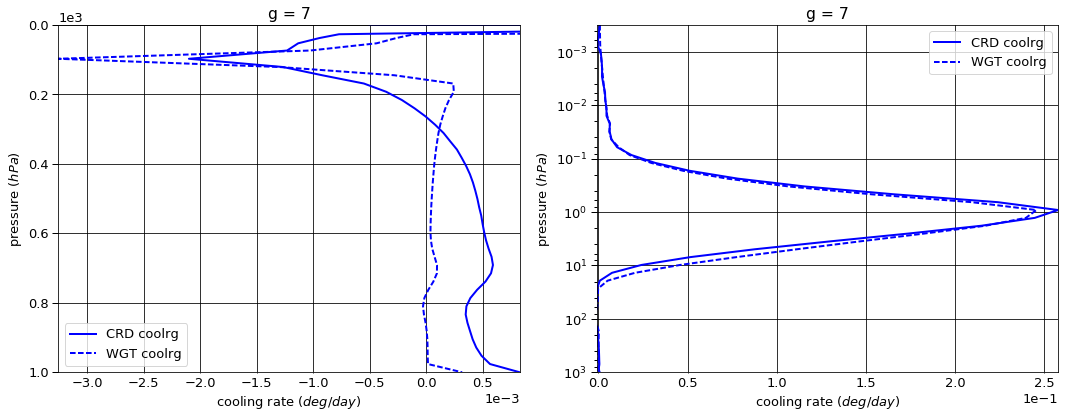

# Figure: cooling rate g-group 8

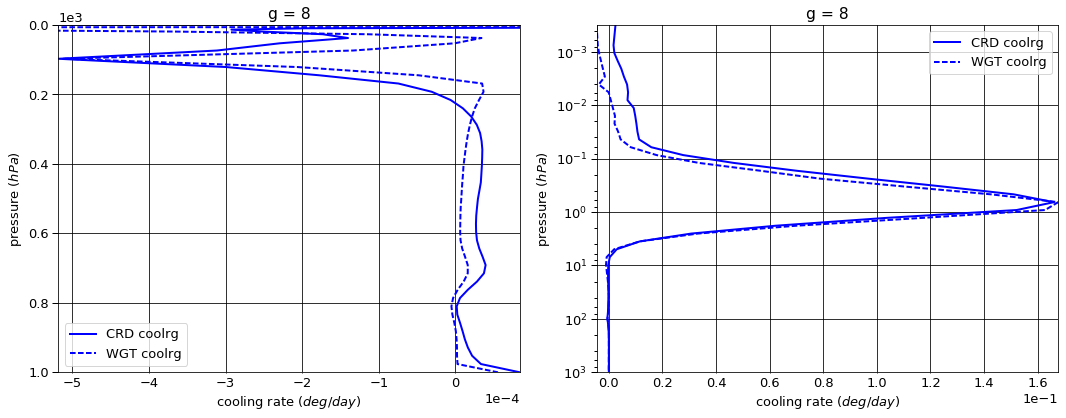

# Figure: cooling rate g-group 9

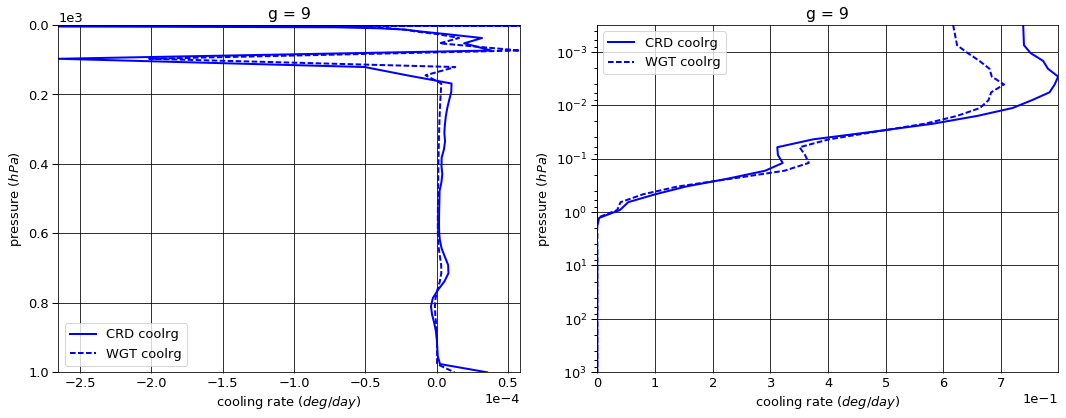

# Figure: cooling rate g-group total

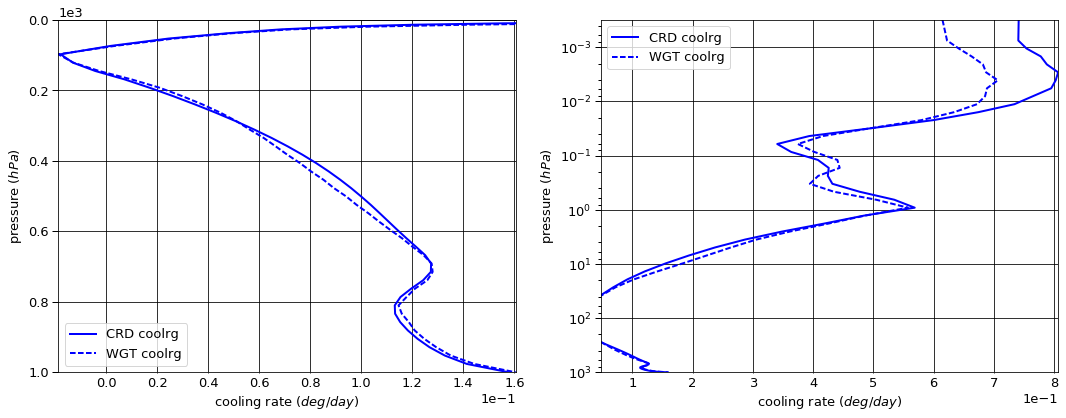

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1     -14.071540  0.000000 -14.071540
  1013.0   76    -14.208093  0.748120 -13.459973
2 0.0      1      -7.916779  0.000000  -7.916779
  1013.0   76     -8.728974  3.252823  -5.476152
3 0.0      1      -6.681202  0.000000  -6.681202
  1013.0   76    -10.229967  8.828880  -1.401087
4 0.0      1      -1.010171  0.000000  -1.010171
  1013.0   76     -2.578258  2.542869  -0.035388
5 0.0      1      -0.792915  0.000000  -0.792915
  1013.0   76     -1.884954  1.748483  -0.136471
6 0.0      1      -0.191785  0.000000  -0.191785
  1013.0   76     -0.471588  0.467371  -0.004217
7 0.0      1      -0.160128  0.000000  -0.160128
  1013.0   76     -0.298479  0.282879  -0.015600
8 0.0      1      -0.028853  0.000000  -0.028853
  1013.0   76     -0.048119  0.047629  -0.000489
9 0.0      1      -0.017177  0.000000  -0.017177
  1013.0   76     -0.043303  0.043198  -0.000105


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1     -14.075251  0.000000 -14.075251
  1013.0   76    -14.208093  0.742751 -13.465341
2 0.0      1      -7.936907  0.000000  -7.936907
  1013.0   76     -8.728974  3.239924  -5.489050
3 0.0      1      -6.658169  0.000000  -6.658169
  1013.0   76    -10.229967  8.962690  -1.267277
4 0.0      1      -0.966423  0.000000  -0.966423
  1013.0   76     -2.578258  2.543728  -0.034530
5 0.0      1      -0.587303  0.000000  -0.587303
  1013.0   76     -1.884954  1.867821  -0.017133
6 0.0      1      -0.191641  0.000000  -0.191641
  1013.0   76     -0.471588  0.470852  -0.000736
7 0.0      1      -0.153362  0.000000  -0.153362
  1013.0   76     -0.298479  0.297587  -0.000892
8 0.0      1      -0.029515  0.000000  -0.029515
  1013.0   76     -0.048119  0.047961  -0.000157
9 0.0      1      -0.016670  0.000000  -0.016670
  1013.0   76     -0.043303  0.043268  -0.000035


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.003711  0.000000 -0.003711
  1013.0   76     0.000000 -0.005369 -0.005368
2 0.0      1     -0.020128  0.000000 -0.020128
  1013.0   76     0.000000 -0.012898 -0.012898
3 0.0      1      0.023033  0.000000  0.023033
  1013.0   76     0.000000  0.133810  0.133810
4 0.0      1      0.043748  0.000000  0.043748
  1013.0   76     0.000000  0.000859  0.000859
5 0.0      1      0.205612  0.000000  0.205612
  1013.0   76     0.000000  0.119338  0.119338
6 0.0      1      0.000144  0.000000  0.000144
  1013.0   76     0.000000  0.003480  0.003480
7 0.0      1      0.006766  0.000000  0.006766
  1013.0   76     0.000000  0.014708  0.014708
8 0.0      1     -0.000662  0.000000 -0.000662
  1013.0   76     0.000000  0.000332  0.000332
9 0.0      1      0.000506  0.000000  0.000506
  1013.0   76     0.000000  0.000071  0.000071

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.000057
  1001.112500 75     0.018842
2 0.000312    1     -0.000142
  1001.112500 75     0.056569
3 0.000312    1     -0.000054
  1001.112500 75     0.067218
4 0.000312    1      0.000037
  1001.112500 75     0.007399
5 0.000312    1     -0.000126
  1001.112500 75     0.006184
6 0.000312    1      0.000075
  1001.112500 75     0.000625
7 0.000312    1      0.000813
  1001.112500 75     0.000828
8 0.000312    1      0.002492
  1001.112500 75     0.000084
9 0.000312    1      0.738160
  1001.112500 75     0.000035


WGT


coolrg
g pressure    layer          
1 0.000312    1     -0.000059
  1001.112500 75     0.019001
2 0.000312    1     -0.000131
  1001.112500 75     0.059503
3 0.000312    1     -0.000017
  1001.112500 75     0.069058
4 0.000312    1      0.000038
  1001.112500 75     0.007678
5 0.000312    1      0.001846
  1001.112500 75     0.004614
6 0.000312    1      0.000098
  1001.112500 75     0.000277
7 0.000312    1      0.000829
  1001.112500 75     0.000317
8 0.000312    1     -0.004538
  1001.112500 75     0.000056
9 0.000312    1      0.616714
  1001.112500 75     0.000012


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.952093e-06
  1001.112500 75     1.590550e-04
2 0.000312    1      1.061106e-05
  1001.112500 75     2.934058e-03
3 0.000312    1      3.672678e-05
  1001.112500 75     1.840816e-03
4 0.000312    1      9.615680e-07
  1001.112500 75     2.785982e-04
5 0.000312    1      1.972051e-03
  1001.112500 75    -1.569576e-03
6 0.000312    1      2.282462e-05
  1001.112500 75    -3.480757e-04
7 0.000312    1      1.543187e-05
  1001.112500 75    -5.102550e-04
8 0.000312    1     -7.030897e-03
  1001.112500 75    -2.854513e-05
9 0.000312    1     -1.214460e-01
  1001.112500 75    -2.292818e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.870550,0.000000,-30.870550
1013.0,76,-38.491734,17.962253,-20.529482



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.615242,0.000000,-30.615242
1013.0,76,-38.491734,18.216583,-20.275151



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.255308,0.00000,0.255308
1013.0,76,0.000000,0.25433,0.254331


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.741199
1001.112500,75,0.157784



WGT


,,coolrg
pressure,layer,
0.000312,1,0.614779
1001.112500,75,0.160517



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.126420
1001.112500,75,0.002733


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.369750,0.376189
2,0.226562,0.227542
3,0.265437,0.261001
4,0.066937,0.065427
5,0.048938,0.048008
6,0.012250,0.011931
7,0.007750,0.007589
8,0.001250,0.001218
9,0.001125,0.001094


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.011442e-25
2,6.375895e-24
3,6.651099e-23
4,6.938182e-22
5,1.602800e-22
6,1.715202e-21
7,1.906144e-21
8,2.053870e-20
9,2.213044e-19


In [24]:
def spreadsheet():
    ng = 9
    ng_refs = [3, 2, 4]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref[::-1], 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.011442e-25,NaN,0.369750,0.376189,0.369750,0.376189,500.0
2,6.375895e-24,63.037680,0.226562,0.227542,0.596313,0.603732,500.0
3,6.651099e-23,10.431632,0.265437,0.261001,0.861750,0.864733,500.0
4,6.938182e-22,10.431632,0.066937,0.065427,0.928687,0.930160,500.0
5,1.602800e-22,0.231011,0.048938,0.048008,0.977625,0.978168,10.0
6,1.715202e-21,10.701287,0.012250,0.011931,0.989875,0.990100,10.0
7,1.906144e-21,1.111323,0.007750,0.007589,0.997625,0.997688,1.0
8,2.053870e-20,10.774999,0.001250,0.001218,0.998875,0.998906,1.0
9,2.213044e-19,10.774999,0.001125,0.001094,1.000000,1.000000,1.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
pd.set_option('display.max_rows', None)
#display.display(
#    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
#                index_col=[0, 1],
#                sep=r'\s+')
#    )
pd.reset_option('display.max_rows')

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')